In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib  # for reading MR images
import tensorflow as tf
import keras as k
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.utils.vis_utils import plot_model
from collections import Counter
from sklearn.metrics import fbeta_score
from sklearn.metrics import jaccard_score
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd
import seaborn as sns
tf.keras.backend.clear_session() # clearing any previous tensorflow sessions

2023-08-29 14:33:21.489383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 14:33:24.219456: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-29 14:33:30.214049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/opt/Python/Python-3.10.1/lib:/opt/ucl/lib:/usr/X11R6/lib
2023-08-29 14:33:30.214678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

In [2]:
#Loading Dataset
t = time.process_time()

# Base directory path where the patient data is stored
base_directory_path = '/cluster/project2/UCSF_PDGM_dataset/UCSF-PDGM-v3/'

# Patient directories are named 'UCSF-PDGM-XXXX_nifti', where XXXX is the patient ID
all_patient_ids = [f"UCSF-PDGM-{str(i).zfill(4)}" for i in range(4, 542)]  # This will generate IDs from 0001 to 0541

# Excluded patients list because of FileNotFoundError, IndexError, ImageFileError
exclude_unavailbale_patients = {'UCSF-PDGM-0006', 'UCSF-PDGM-0028', 'UCSF-PDGM-0051', 'UCSF-PDGM-0052', 'UCSF-PDGM-0054', 'UCSF-PDGM-0060', 
                                'UCSF-PDGM-0062', 'UCSF-PDGM-0081', 'UCSF-PDGM-0098', 'UCSF-PDGM-0100', 'UCSF-PDGM-0108', 'UCSF-PDGM-0110',
                                'UCSF-PDGM-0117', 'UCSF-PDGM-0120', 'UCSF-PDGM-0125', 'UCSF-PDGM-0138', 'UCSF-PDGM-0171', 'UCSF-PDGM-0175',
                                'UCSF-PDGM-0177', 'UCSF-PDGM-0181', 'UCSF-PDGM-0192', 'UCSF-PDGM-0194', 'UCSF-PDGM-0199', 'UCSF-PDGM-0203',
                                'UCSF-PDGM-0206', 'UCSF-PDGM-0211', 'UCSF-PDGM-0216', 'UCSF-PDGM-0217', 'UCSF-PDGM-0218', 'UCSF-PDGM-0219',
                                'UCSF-PDGM-0220', 'UCSF-PDGM-0221', 'UCSF-PDGM-0222', 'UCSF-PDGM-0224', 'UCSF-PDGM-0226', 'UCSF-PDGM-0230',
                                'UCSF-PDGM-0231', 'UCSF-PDGM-0232', 'UCSF-PDGM-0233', 'UCSF-PDGM-0234', 'UCSF-PDGM-0235', 'UCSF-PDGM-0236',
                                'UCSF-PDGM-0237', 'UCSF-PDGM-0238', 'UCSF-PDGM-0239', 'UCSF-PDGM-0240', 'UCSF-PDGM-0241', 'UCSF-PDGM-0242',
                                'UCSF-PDGM-0244', 'UCSF-PDGM-0245', 'UCSF-PDGM-0246', 'UCSF-PDGM-0247', 'UCSF-PDGM-0248', 'UCSF-PDGM-0249',
                                'UCSF-PDGM-0250', 'UCSF-PDGM-0251', 'UCSF-PDGM-0252', 'UCSF-PDGM-0254', 'UCSF-PDGM-0255', 'UCSF-PDGM-0256',
                                'UCSF-PDGM-0257', 'UCSF-PDGM-0258', 'UCSF-PDGM-0259', 'UCSF-PDGM-0260', 'UCSF-PDGM-0261', 'UCSF-PDGM-0262',
                                'UCSF-PDGM-0263', 'UCSF-PDGM-0264', 'UCSF-PDGM-0265', 'UCSF-PDGM-0266', 'UCSF-PDGM-0267', 'UCSF-PDGM-0268',
                                'UCSF-PDGM-0269', 'UCSF-PDGM-0271', 'UCSF-PDGM-0272', 'UCSF-PDGM-0274', 'UCSF-PDGM-0277', 'UCSF-PDGM-0278',
                                'UCSF-PDGM-0281', 'UCSF-PDGM-0282', 'UCSF-PDGM-0286', 'UCSF-PDGM-0289', 'UCSF-PDGM-0292', 'UCSF-PDGM-0293',
                                'UCSF-PDGM-0294', 'UCSF-PDGM-0298', 'UCSF-PDGM-0299', 'UCSF-PDGM-0300', 'UCSF-PDGM-0301', 'UCSF-PDGM-0302',
                                'UCSF-PDGM-0305', 'UCSF-PDGM-0307', 'UCSF-PDGM-0308', 'UCSF-PDGM-0315', 'UCSF-PDGM-0322', 'UCSF-PDGM-0326',
                                'UCSF-PDGM-0327', 'UCSF-PDGM-0331', 'UCSF-PDGM-0345', 'UCSF-PDGM-0349', 'UCSF-PDGM-0351', 'UCSF-PDGM-0352',
                                'UCSF-PDGM-0357', 'UCSF-PDGM-0365', 'UCSF-PDGM-0371', 'UCSF-PDGM-0374', 'UCSF-PDGM-0378', 'UCSF-PDGM-0383',
                                'UCSF-PDGM-0388', 'UCSF-PDGM-0395', 'UCSF-PDGM-0408', 'UCSF-PDGM-0436', 'UCSF-PDGM-0437', 'UCSF-PDGM-0438',
                                'UCSF-PDGM-0439', 'UCSF-PDGM-0440', 'UCSF-PDGM-0441', 'UCSF-PDGM-0442', 'UCSF-PDGM-0444', 'UCSF-PDGM-0445', 
                                'UCSF-PDGM-0446', 'UCSF-PDGM-0448', 'UCSF-PDGM-0449', 'UCSF-PDGM-0456', 'UCSF-PDGM-0465', 'UCSF-PDGM-0466', 
                                'UCSF-PDGM-0468', 'UCSF-PDGM-0469', 'UCSF-PDGM-0473', 'UCSF-PDGM-0474', 'UCSF-PDGM-0475', 'UCSF-PDGM-0476', 
                                'UCSF-PDGM-0477', 'UCSF-PDGM-0478', 'UCSF-PDGM-0482', 'UCSF-PDGM-0483', 'UCSF-PDGM-0485', 'UCSF-PDGM-0486',
                                'UCSF-PDGM-0489', 'UCSF-PDGM-0490', 'UCSF-PDGM-0500', 'UCSF-PDGM-0501', 'UCSF-PDGM-0530', 'UCSF-PDGM-0534', 
                                'UCSF-PDGM-0535', 'UCSF-PDGM-0537', 'UCSF-PDGM-0540', 'UCSF-PDGM-0541'}

all_data_dti_eddy_fa = []
all_data_t1c_bias = []
num_of_images = 0
num_of_patients = 0

print("Loading images: ", end="")
for patient_id in all_patient_ids:

    if patient_id in exclude_unavailbale_patients:
        continue
    
    # Construct file paths for the current patient
    dti_eddy_fa_path = os.path.join(base_directory_path, f"{patient_id}_nifti", f"{patient_id}_DTI_eddy_FA.nii.gz")
    t1c_bias_path = os.path.join(base_directory_path, f"{patient_id}_nifti", f"{patient_id}_T1c_bias.nii.gz")
    
    # Load the images
    image_dti_eddy_fa = nib.load(dti_eddy_fa_path)
    image_t1c_bias = nib.load(t1c_bias_path)
    
    # Get the image data as numpy arrays
    data_dti_eddy_fa = image_dti_eddy_fa.get_fdata()
    data_t1c_bias = image_t1c_bias.get_fdata()
    
    slice_start = 70  # Starting slice number
    slice_end = 85    # End slice number

    # Append the data to the lists
    for i in range(slice_start, slice_end):
        all_data_dti_eddy_fa.append(data_dti_eddy_fa[:, :, i])
        all_data_t1c_bias.append(data_t1c_bias[:, :, i])
        num_of_images = num_of_images + 1
    num_of_patients = num_of_patients + 1
    print(".", end="")

print(" => Images Loaded.")
elapsed_time = time.process_time() - t
print("Total time taken to load",num_of_images, "images of", num_of_patients,"patients:",elapsed_time, "seconds or", elapsed_time//60, "minutes.")
print("Total number of slices considered:", slice_end-slice_start)
# Convert lists to numpy arrays for further processing if needed
all_data_dti_eddy_fa = np.asarray(all_data_dti_eddy_fa)
all_data_t1c_bias = np.asarray(all_data_t1c_bias)

Loading images: ...................................................................................................................................................................................................................................................................................................................................................................................................... => Images Loaded.
Total time taken to load 5850 images of 390 patients: 191.19332017300002 seconds or 3.0 minutes.
Total number of slices considered: 15


In [3]:
# Shape of the final input and output data
print(all_data_dti_eddy_fa.shape)
print(all_data_t1c_bias.shape)

(5850, 240, 240)
(5850, 240, 240)


In [4]:
all_data_dti_eddy_fa_m = np.max(all_data_dti_eddy_fa)
all_data_dti_eddy_fa_mi = np.min(all_data_dti_eddy_fa)
print("Maximum pixel value in the input image DTI_Eddy_FA:", all_data_dti_eddy_fa_m)
print("Minimum pixel value in the input image DTI_Eddy_FA:", all_data_dti_eddy_fa_mi)

# Normalizing the input image data
print("After Normalization")
all_data_dti_eddy_fa = (all_data_dti_eddy_fa - all_data_dti_eddy_fa_mi) / (all_data_dti_eddy_fa_m - all_data_dti_eddy_fa_mi)
print("Minimum pixel value in the input image DTI_Eddy_FA:", np.min(all_data_dti_eddy_fa))
print("Maximum pixel value in the input image DTI_Eddy_FA:", np.max(all_data_dti_eddy_fa))

Maximum pixel value in the input image DTI_Eddy_FA: 1.2145510357731837
Minimum pixel value in the input image DTI_Eddy_FA: 0.0
After Normalization
Minimum pixel value in the input image DTI_Eddy_FA: 0.0
Maximum pixel value in the input image DTI_Eddy_FA: 1.0


In [5]:
all_data_t1c_bias_m = np.max(all_data_t1c_bias)
all_data_t1c_bias_mi = np.min(all_data_t1c_bias)
print("Maximum pixel value in the output image T1c_bias:", all_data_t1c_bias_m)
print("Minimum pixel value in the output image T1c_bias:", all_data_t1c_bias_mi)

#Normalizing the output image data (although not needed)
print("After normalization")
all_data_t1c_bias = (all_data_t1c_bias - all_data_t1c_bias_mi) / (all_data_t1c_bias_m - all_data_t1c_bias_mi)
print("Minimum pixel value in the output image T1c_bias:", np.min(all_data_t1c_bias))
print("Maximum pixel value in the output image T1c_bias:", np.max(all_data_t1c_bias))

Maximum pixel value in the output image T1c_bias: 15849.36417222023
Minimum pixel value in the output image T1c_bias: 0.0
After normalization
Minimum pixel value in the output image T1c_bias: 0.0
Maximum pixel value in the output image T1c_bias: 1.0


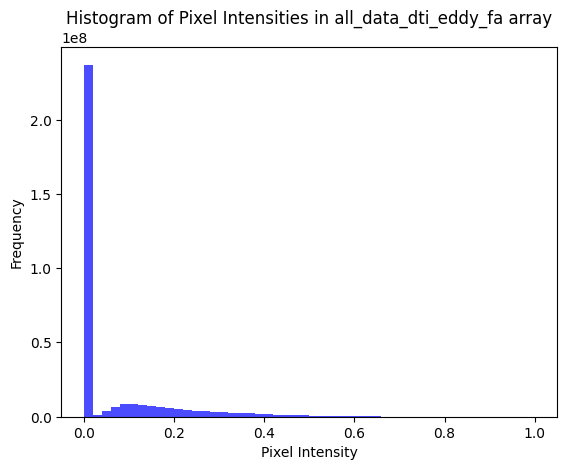

In [6]:
# Create a frequency histogram of the normalized input image dataset
input_flattened_data = all_data_dti_eddy_fa.flatten()

plt.hist(input_flattened_data, bins=50, color='blue', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities in all_data_dti_eddy_fa array')
plt.show()

In [7]:
# Count the occurrences of each value in the input_flattened_data
counter = Counter(input_flattened_data)

# Print the frequency count of value 0 and 1
print("Frequency of value 0:", counter[0])
print("Frequency of value 1:", counter[1])

Frequency of value 0: 236900479
Frequency of value 1: 1


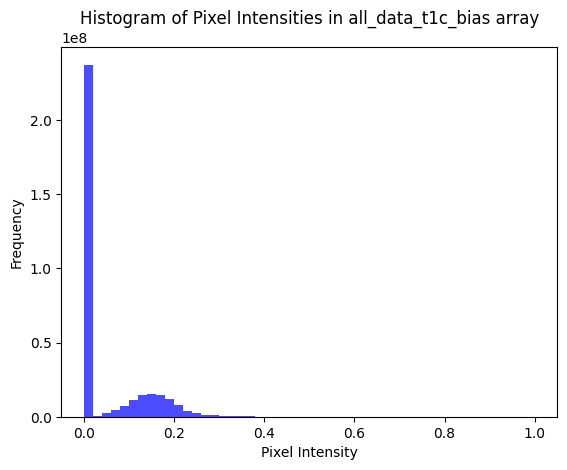

In [8]:
# Create a frequency histogram of the tumour masked output image dataset
output_flattened_data = all_data_t1c_bias.flatten()

plt.hist(output_flattened_data, bins=50, color='blue', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities in all_data_t1c_bias array')
plt.show()

In [9]:
# Count the occurrences of each value in the output_flattened_data
counter = Counter(output_flattened_data)

# Print the frequency count of value 0 and 1
print("Frequency of value 0:", counter[0])
print("Frequency of value 1:", counter[1])

Frequency of value 0: 236540328
Frequency of value 1: 1


In [10]:
X = all_data_dti_eddy_fa.reshape(-1,240,240,1)
Y = all_data_t1c_bias.reshape(-1,240,240,1)

print("Collective shape of X dataset:", X.shape)
print("Collective shape of Y dataset:", Y.shape)

# First, splitting the data into training/testing and unseen data (e.g., 98% train/test, 2% unseen)
X_temp, X_unseen, Y_temp, Y_unseen = train_test_split(X, Y, test_size=0.02, random_state=22)

# Then, splitting the training/testing data into training and test sets (e.g., 70% train, 30% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_temp, Y_temp, test_size=0.3, random_state=42)

# Now we have three datasets: training (X_train, Y_train), testing (X_test, Y_test), and unseen (X_unseen, Y_unseen)

print("X_unseen shape:", X_unseen.shape)
print("Y_unseen shape:", Y_unseen.shape)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Collective shape of X dataset: (5850, 240, 240, 1)
Collective shape of Y dataset: (5850, 240, 240, 1)
X_unseen shape: (117, 240, 240, 1)
Y_unseen shape: (117, 240, 240, 1)
X_train shape: (4013, 240, 240, 1)
Y_train shape: (4013, 240, 240, 1)
X_test shape: (1720, 240, 240, 1)
Y_test shape: (1720, 240, 240, 1)


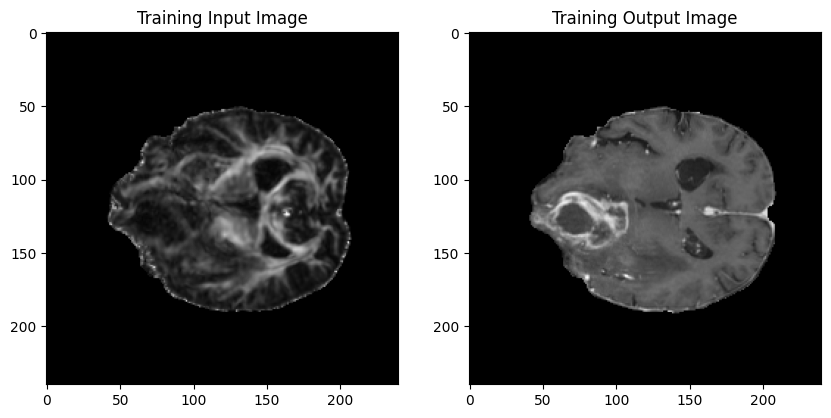

In [11]:
# Sample training Input image and its corresponding output image
plt.figure(figsize=[10,10])

plt.subplot(121)
curr_img = np.reshape(X_train[2500], (240,240))
plt.title("Training Input Image")
plt.imshow(curr_img, cmap='gray')

plt.subplot(122)
curr_img = np.reshape(Y_train[2500], (240,240))
plt.title("Training Output Image")
plt.imshow(curr_img, cmap='gray')

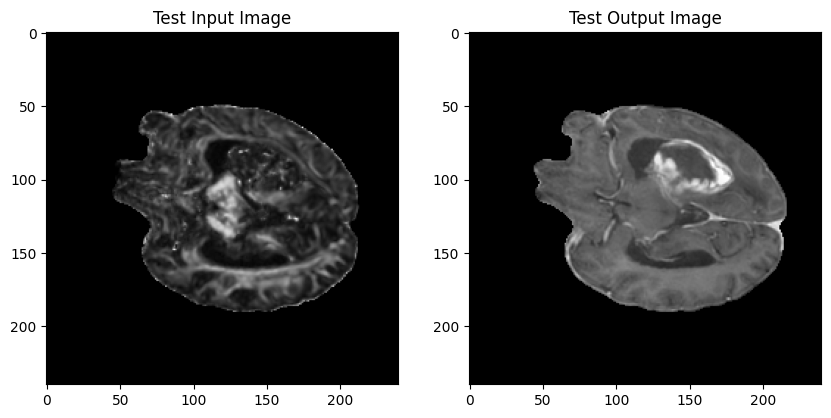

In [12]:
# Sample test Input image and its corresponding output image

plt.figure(figsize=[10,10])

plt.subplot(121)
curr_img = np.reshape(X_test[650], (240,240))
plt.title("Test Input Image")
plt.imshow(curr_img, cmap='gray')

plt.subplot(122)
curr_img = np.reshape(Y_test[650], (240,240))
plt.title("Test Output Image")
plt.imshow(curr_img, cmap='gray')

In [13]:
def unet_model(input_size=(240, 240, 1)):
    inputs = Input(input_size)
    
    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c4)

    # Expanding path
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [14]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss= 'binary_crossentropy', metrics=[dice_coef])
model.summary()

2023-08-29 14:43:48.582697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 14:43:53.194416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11477 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 240, 240, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

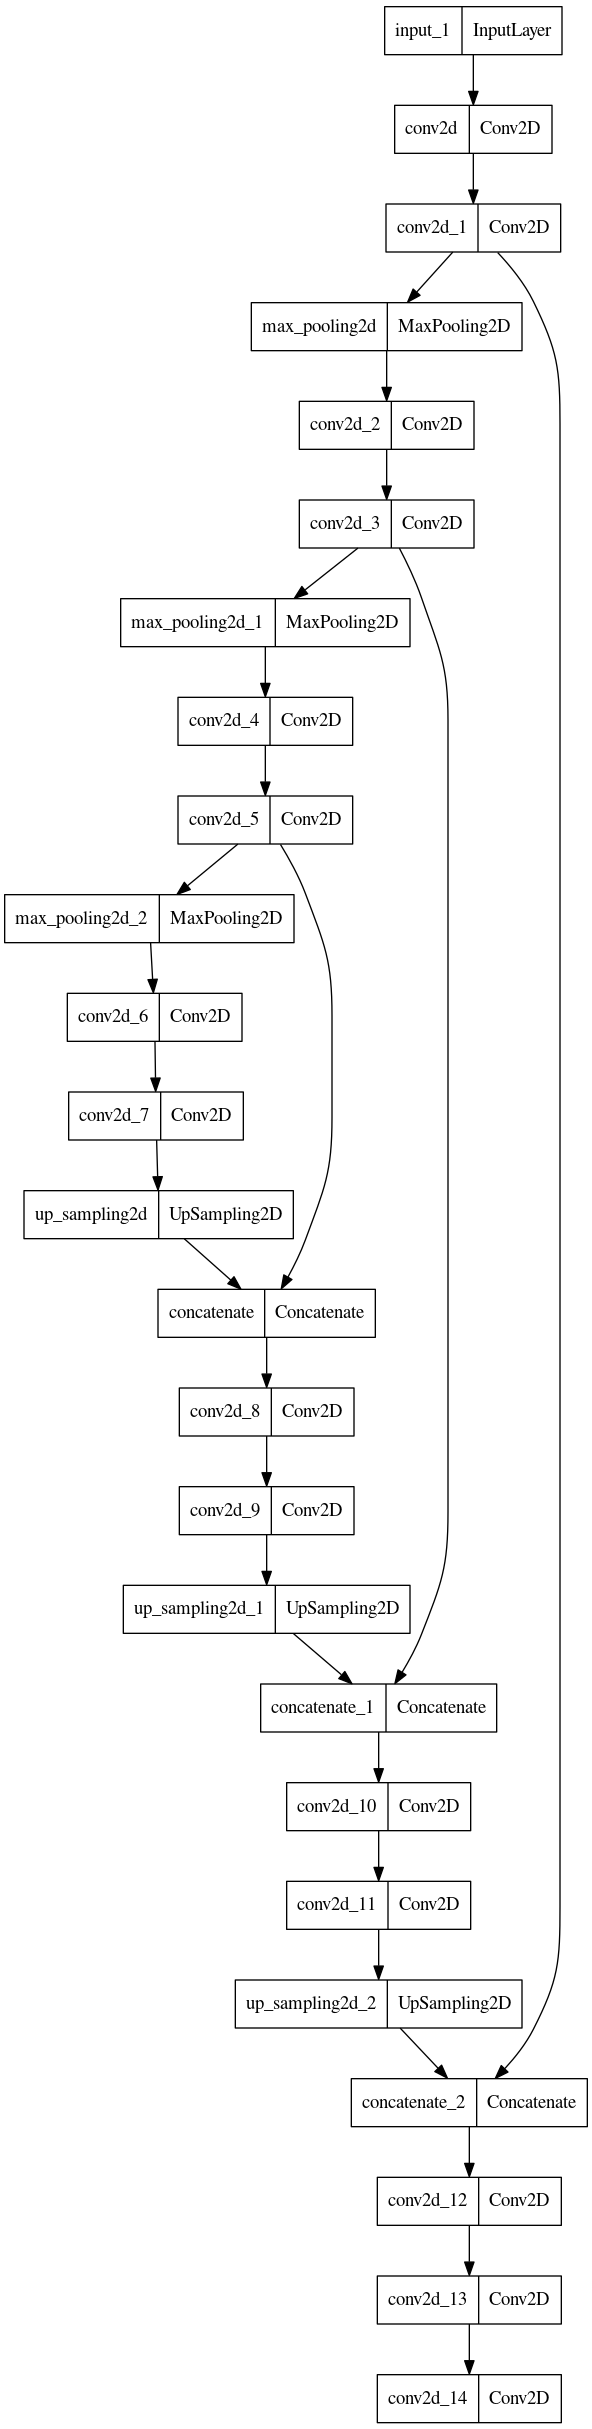

In [15]:
plot_model(model)

In [16]:
t = time.process_time()
model_train = model.fit(X_train, Y_train, batch_size=16,epochs=100,verbose=1)
elapsed_time = time.process_time() - t
print("\nTotal time taken to train the model:", elapsed_time//60, "minutes")

Epoch 1/100


2023-08-29 14:44:06.057393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-08-29 14:44:11.148156: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-29 14:44:11.436861: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


250/251 [============================>.] - ETA: 0s - loss: 0.1470 - dice_coef: 0.1520

2023-08-29 14:46:21.952944: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-08-29 14:46:22.220882: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


251/251 [==============================] - 143s 523ms/step - loss: 0.1469 - dice_coef: 0.1520
Epoch 2/100
251/251 [==============================] - 132s 526ms/step - loss: 0.1294 - dice_coef: 0.1567
Epoch 3/100
251/251 [==============================] - 132s 527ms/step - loss: 0.1291 - dice_coef: 0.1568
Epoch 4/100
251/251 [==============================] - 132s 526ms/step - loss: 0.1291 - dice_coef: 0.1573
Epoch 5/100
251/251 [==============================] - 131s 524ms/step - loss: 0.1290 - dice_coef: 0.1577
Epoch 6/100
251/251 [==============================] - 132s 524ms/step - loss: 0.1288 - dice_coef: 0.1579
Epoch 7/100
251/251 [==============================] - 132s 524ms/step - loss: 0.1287 - dice_coef: 0.1582
Epoch 8/100
251/251 [==============================] - 131s 524ms/step - loss: 0.1287 - dice_coef: 0.1584
Epoch 9/100
251/251 [==============================] - 131s 522ms/step - loss: 0.1287 - dice_coef: 0.1586
Epoch 10/100
251/251 [==============================] - 13

In [17]:
# Defining a function for calculating IoU
def calculate_iou(y_true, y_pred):
    y_true = np.round(y_true).flatten()
    y_pred = np.round(y_pred).flatten()
    return jaccard_score(y_true, y_pred, zero_division=1)

# Defining a function for calculating PSNR
def calculate_psnr(y_true, y_pred):
    return psnr(y_true, y_pred, data_range=1.0)

# Defining a function for calculating the F2 score
def calculate_f2(y_true, y_pred):
    y_true = np.round(y_true).flatten()
    y_pred = np.round(y_pred).flatten()
    return fbeta_score(y_true, y_pred, beta=2, zero_division=1)

# Evaluating the model on the test data
loss, dice_score = model.evaluate(X_test, Y_test)
print("Loss:", loss)
print("Dice Score:", dice_score)

# Predicting on the test data
pred = model.predict(X_test)

# Initialize variables to store IoU, PSNR, and F2 scores of all the test data slices
iou_scores = []
psnr_scores = []
f2_scores = []

# Iterate through the test data and calculate IoU, PSNR, and F2 scores for each prediction
for i in range(len(X_test)):
    iou_scores.append(calculate_iou(Y_test[i], pred[i]))
    psnr_scores.append(calculate_psnr(Y_test[i], pred[i]))
    f2_scores.append(calculate_f2(Y_test[i], pred[i]))

# Print the average IoU, PSNR, and F2 scores
print("Average IoU:", np.mean(iou_scores))
print("Average PSNR:", np.mean(psnr_scores))
print("Average F2 Score:", np.mean(f2_scores))

54/54 [==============================] - 22s 351ms/step - loss: 0.1274 - dice_coef: 0.1693
Loss: 0.12740764021873474
Dice Score: 0.16929657757282257
54/54 [==============================] - 17s 310ms/step
Average IoU: 0.5297131288748945
Average PSNR: 34.87678675144061
Average F2 Score: 0.5926784057978093


1/1 [==============================] - 0s 32ms/step


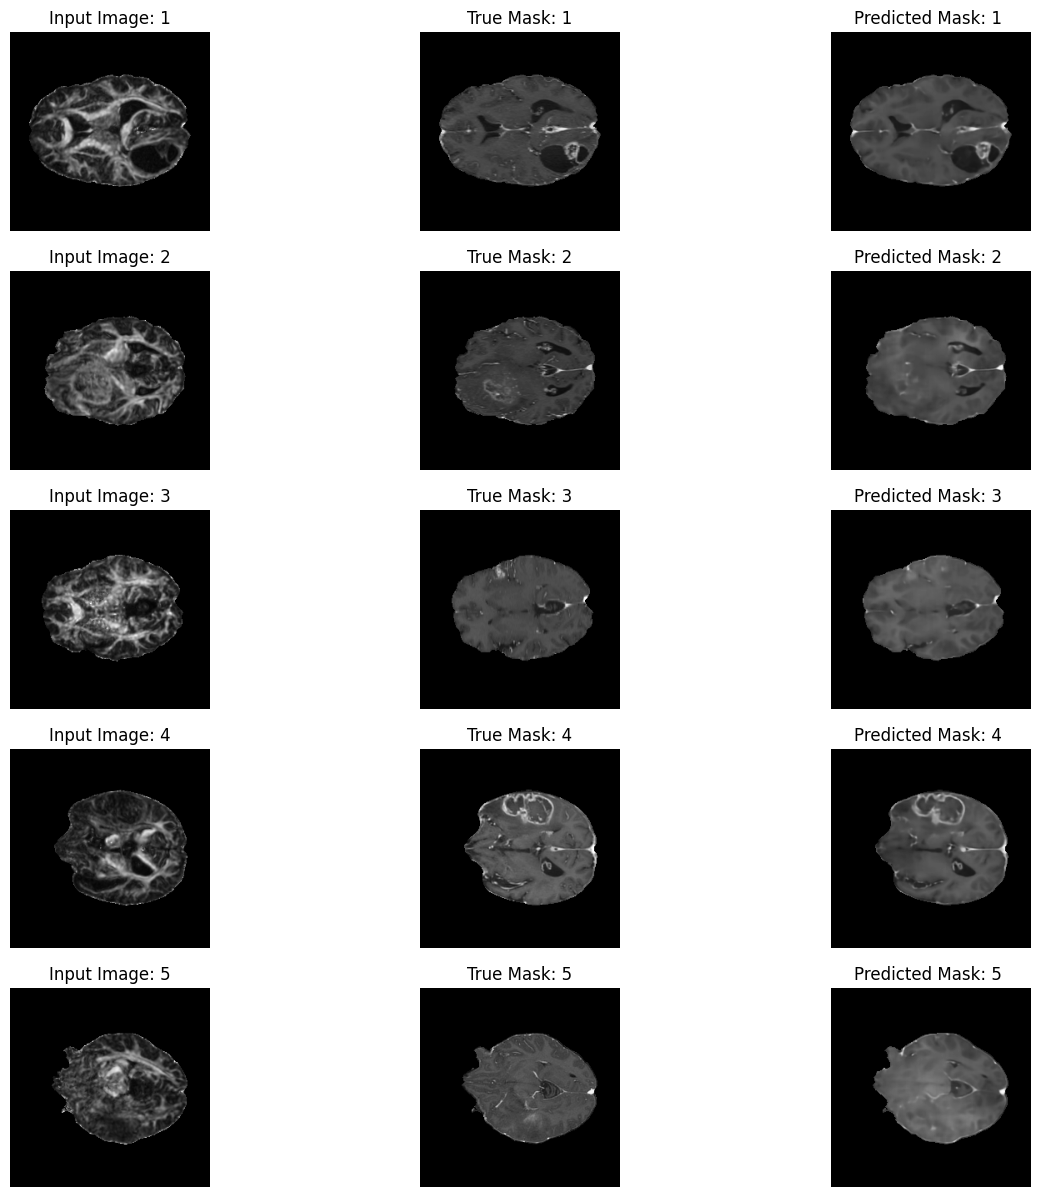

In [18]:
# Choosing 5 random image slices to visualize from the test set
indices = [100, 200, 300, 400, 500]
image_counter = 1

plt.figure(figsize=(15, 15))

for i, index in enumerate(indices):
    # Get the input image, true mask, and predicted mask
    input_image = X_test[index]
    true_mask = Y_test[index]
    predicted_mask = model.predict(input_image[np.newaxis, ...])[0]  # Adding a batch dimension for prediction
    
    # Display the input image
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(input_image[..., 0], cmap='gray')
    plt.title(f'Input Image: {image_counter}')
    plt.axis('off')
    
    # Display the true mask
    plt.subplot(5, 3, 3*i+2)
    plt.imshow(true_mask[..., 0], cmap='gray')
    plt.title(f'True Mask: {image_counter}')
    plt.axis('off')
    
    # Display the predicted mask
    plt.subplot(5, 3, 3*i+3)
    plt.imshow(predicted_mask[..., 0], cmap='gray')
    plt.title(f'Predicted Mask: {image_counter} ')
    plt.axis('off')

    image_counter = image_counter+1

plt.show()

1/1 [==============================] - 0s 33ms/step


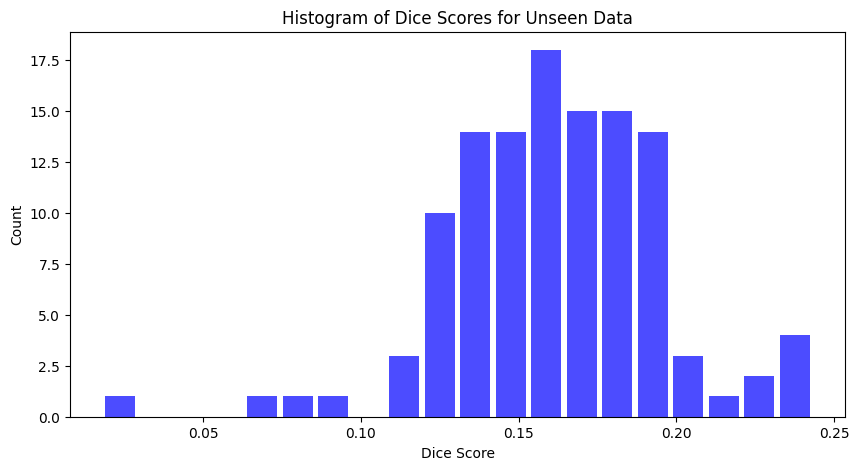

In [19]:
dice_scores = []

for i in range(len(X_unseen)):
    predicted_mask = model.predict(np.expand_dims(X_unseen[i], axis=0))
    predicted_mask = np.squeeze(predicted_mask)
    ground_truth_mask = Y_unseen[i].squeeze()

    # Dice Score
    dice_score = (2 * np.sum(predicted_mask * ground_truth_mask)) / (np.sum(predicted_mask) + np.sum(ground_truth_mask))
    dice_scores.append(dice_score)

df = pd.DataFrame({
    'DS DTIEddyFAToT1cBias': dice_scores
})

df.to_csv('dataframeDTIEddyFAToT1cBias.csv', index=False)

# Visualization of Dice Scores
plt.figure(figsize=(10, 5))
plt.hist(dice_scores, bins=20, color='b', alpha=0.7, rwidth=0.85)
plt.xlabel('Dice Score')
plt.ylabel('Count')
plt.title('Histogram of Dice Scores for Unseen Data')
plt.show()

In [20]:
df = pd.read_csv('dataframeDTIEddyFAToT1cBias.csv')
df.head(20)

,DS DTIEddyFAToT1cBias
0,0.196674
1,0.184350
2,0.167040
3,0.237331
4,0.135547
5,0.171058
6,0.154521
7,0.163275
8,0.168769
9,0.187487


In [21]:
df.tail(10)

,DS DTIEddyFAToT1cBias
107,0.185967
108,0.158729
109,0.120715
110,0.018176
111,0.193261
112,0.120550
113,0.204788
114,0.177303
115,0.128118
116,0.147083


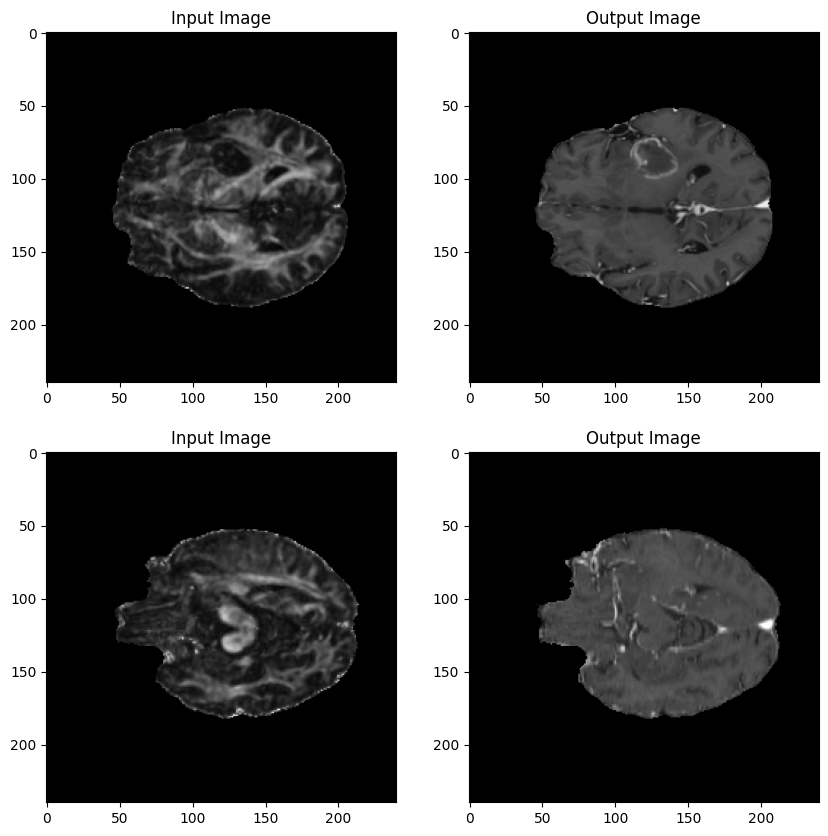

In [22]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.imshow(X_unseen[2], cmap='gray')
plt.title('Input Image')

plt.subplot(2,2,2)
plt.imshow(Y_unseen[2], cmap='gray')
plt.title('Output Image')

plt.subplot(2,2,3)
plt.imshow(X_unseen[4], cmap='gray')
plt.title('Input Image')

plt.subplot(2,2,4)
plt.imshow(Y_unseen[4], cmap='gray')
plt.title('Output Image')

plt.show()

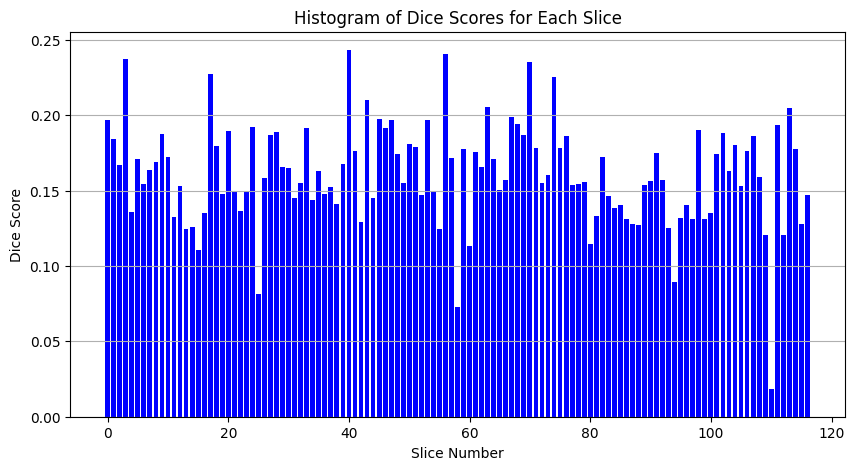

In [23]:
# Extract the Dice scores and slice numbers from the DataFrame
dice_scores = df['DS DTIEddyFAToT1cBias'].values
slice_numbers = df.index.values

# Create a histogram of the Dice scores for each slice number
plt.figure(figsize=(10, 5))
plt.bar(slice_numbers, dice_scores, color='blue')
plt.xlabel('Slice Number')
plt.ylabel('Dice Score')
plt.title('Histogram of Dice Scores for Each Slice')
plt.grid(axis='y')
plt.show()